# Model project

In [232]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In this project we analyze a consumer problem with a CES utility function and two goods, x1 and x2.

The utility function: alpha is a preference parameter and rho is the elasticity parameter
The income is 30 and the prices of the goods are: \\[ p_1=2, p_2=4\\].

First we investigate the jacobian and hessian matrix and how to use gradient based optimizers. In this section we use the *minimize_gradient_descent()* method.

In the next section the budget constraint is introduced and we ty to solve the consumer problem using a *Multi-dimensional constrained solver*.

After this the consumer problem is solved by using the optimizer **SLSQP**.

In the last section we introduce an extension to the problem where we impose a tax on good x2, which increases the price p2 with 0.5 for each consumed x2.  

Consider the **CES utility function**:

\\[ f(\boldsymbol{x}) = u(x_1,x_2) =(\alpha x_{1}^{-\rho}+(1-\alpha) x_{2}^{-\rho})^{-1/\rho} \\]

We choose the parameters:

\\[ \alpha=0.2 \\]

\\[ \rho=-0.2 \\]

In [233]:
sm.init_printing(use_unicode=True)
x1 = sm.symbols('x_1')
x2 = sm.symbols('x_2')
f = (0.2*x1**(2) + (1-0.2)*x2**(2))**(1/2)

Find the Jacobian matrix:

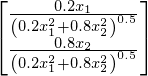

In [234]:
Df = sm.Matrix([sm.diff(f,i) for i in [x1,x2]])
Df

Find the Hessian matrix:

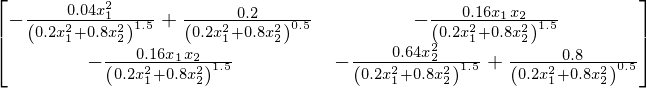

In [235]:
Hf = sm.Matrix([[sm.diff(f,i,j) for j in [x1,x2]] for i in [x1,x2]])
Hf

I now define the function and the matrixes:

In [236]:
def _ces(x1,x2):
    return (0.2*x1**(2) + (1-0.2)*x2**(2))**(1/2)
def ces(x):
    return _ces(x[0],x[1])
def ces_jac(x):
    return np.array([(0.2*x[0])/(0.2*x[0]**2+0.8*x[1]**2)**0.50,(0.8*x[1])/((0.2*x[0]**2+0.8*x[1]**2)**0.5)])
def ces_hess(x):
    return np.array([0.2/(0.2*x[0]**2+0.8*x[1]**2)**0.5-(0.04*x[0]**2)/(0.2*x[0]**2+0.8*x[1]**2)**1.5,-(0.16*x[0]*x[1])/(0.2*x[0]**2+0.8*x[1]**2)**1.5,-(0.16*x[0]*x[1])/(0.2*x[0]**2+0.8*x[1]**2)**1.5,0.8/(0.2*x[0]**2+0.8*x[1]**2)**0.5-(0.64*x[1]**2)/(0.2*x[0]**2+0.8*x[1]**2)**1.5])


I can now plot the function in 3D by using the definitions:

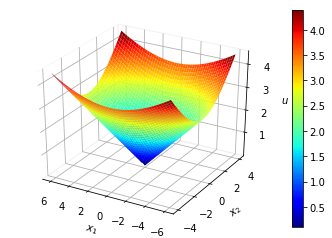

In [237]:
# Grids:
x1_vec = np.linspace(-6,6,500)
x2_vec = np.linspace(-4,4,500)
x1_grid,x2_grid = np.meshgrid(x1_vec,x2_vec,indexing='ij')
ces_grid = _ces(x1_grid,x2_grid)

# Figure:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid,x2_grid,ces_grid,cmap=cm.jet)

# Labels:
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$u$')

ax.invert_xaxis()
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

#Color:
fig.colorbar(cs);

This figure shows the CES utility funtion. It shows that utility is smallest when x1 and x2 is equal to zero. Utility increases when x1 and x2 increases. Further it shows that x2 gives more utility than x1.

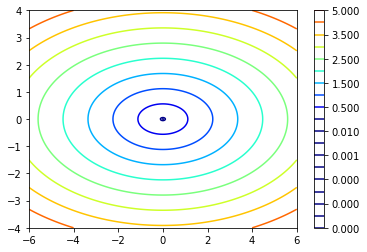

In [238]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
levels = [1e-6,5*1e-6,1e-5,5*1e-5,1e-4,5*1e-4,1e-3,5*1e-3,1e-2,5*1e-2,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,5.00]
cs = ax.contour(x1_grid,x2_grid,ces_grid,levels=levels,cmap=cm.jet)
fig.colorbar(cs);

Here we see a different kind of plot. It shows the same but in 2D. Utility is increased when x1 and x2 is increased. The circles are oval which shows that x2 give more utility than x1.  

# Optimizing with gradient based optimizer

**Now we wish to optimize using the algorithm:** `minimize_gradient_descent()`

The idea is to make some guesses on x0, compute f(x0), find a step size and update guess. Keep doing this until it converges.  

In [239]:
def minimize_gradient_descent(f,x0,jac,alphas=[0.01,0.05,0.1,0.25,0.5,1],max_iter=5000,tol=1e-8):
    """ minimize function with gradient descent
        
    Args:

        f (callable): function
        x0 (float): initial value
        jac (callable): jacobian
        alpha (list): potential step sizes
        max_iter (int): maximum number of iterations
        tol (float): tolerance
        
    Returns:
    
        x (float): root
        n (int): number of iterations used
        
    """
    
    # step 1: initialize
    x = x0
    fx = f(x0)
    n = 1
    
    # step 2-6: iteration
    while n < max_iter:
            
        x_prev = x
        fx_prev = fx
        
        # step 2: evaluate gradient
        jacx = jac(x)
        
        # step 3: find good step size 
        fx_ast = np.inf
        alpha_ast = np.nan
        for alpha in alphas:
            x = x_prev - alpha*jacx
            fx = f(x)
            if fx < fx_ast:
                fx_ast = fx
                alpha_ast = alpha
        
        # step 4: update guess
        x = x_prev - alpha_ast*jacx
                            
        # step 5: check convergence
        fx = f(x)
        if abs(fx-fx_prev) < tol:
            break
            
        # d. update i
        n += 1
        
    return x,n

In [240]:
x0 = np.array([5,4])
x,n = minimize_gradient_descent(ces,x0,ces_jac,alphas=[0.01,0.05,0.1,0.25,0.5,1])
print(n,x,ces(x))

5000 [9.8813129e-324 4.2335895e-003] 0.0037866375632192124


**Solution:** We don't find any convergence and therefore no solution using the gradient based optimizer. Therefore we now try using the SLSQP optimizer, but still by iteration over gradient evaluations.

In [241]:
def collect(x):
    
    global evals 
    global x0
    global x1s
    global x2s
    global fs
    
    if evals == 0:
        x1s = [x0[0]] 
        x2s = [x0[1]]
        fs = [ces(x0)]
        
    x1s.append(x[0])
    x2s.append(x[1])
    fs.append(ces(x))
    evals += 1

In [242]:
def contour():
    
    global evals
    global x1s
    global x2s
    global fs
    
# Code for plotting the result:
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,2,1)
    levels = [1e-6,5*1e-6,1e-5,5*1e-5,1e-4,5*1e-4,1e-3,5*1e-3,1e-2,5*1e-2,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,5.00]
    cs = ax.contour(x1_grid,x2_grid,ces_grid,levels=levels,cmap=cm.jet)
    fig.colorbar(cs)
    ax.plot(x1s,x2s,'-o',ms=4,color='black')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    ax = fig.add_subplot(1,2,2)
    ax.plot(np.arange(evals+1),fs,'-o',ms=4,color='black')
    ax.set_xlabel('iteration')
    ax.set_ylabel('function value')

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.859724780840724e-07
            Iterations: 23
            Function evaluations: 43
            Gradient evaluations: 23


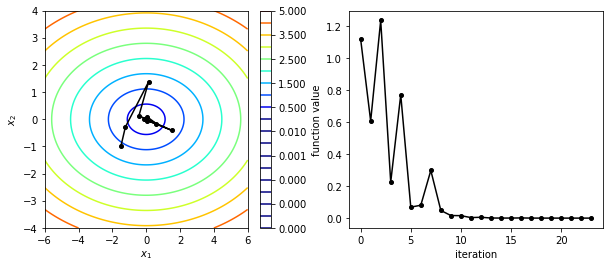

In [243]:
evals = 0
x0 = [-1.5,-1]
result = optimize.minimize(ces,x0,jac=ces_jac,
                           method='SLSQP',
                           bounds=((-2,2),(-2,2)),
                           callback=collect,
                           options={'disp':True})
contour()

We now see some convergence in the function with 23 iterations. 

# Optimization problem

Optimization using the **SLSQP** method.

Consider now the consumer problem given by:

\\[
\begin{eqnarray*}
V(p_{1},p_{2},I) & = & \max_{x_{1},x_{2}}u(x_{1},x_{2})\\
 & \text{s.t.}\\
p_{1}x_{1}+p_{2}x_{2} & \leq & I\\ 
p_{1},p_{2},I>0\\
x_{1},x_{2} & \geq & 0
\end{eqnarray*}
\\]

where the utility is a CES funtion as described earlier.

We choose the parameters:

\\[ \alpha=0.20 \\]

\\[ \rho=-0.20 \\]

In [244]:
def u_func(x1,x2,alpha=0.20,rho=-0.2):
    return (alpha*x1**(-rho)+(1-alpha)*x2**(-rho))**(-1/rho)

We now try to set a random value for x1 and x2 and calculate the utility:

In [245]:
x1 = 2
x2 = 4
u = u_func(x1,x2)

print(f'x1 = {x1:.1f}, x2 = {x2:.1f} -> u = {u:.4f}') 

x1 = 2.0, x2 = 4.0 -> u = 3.5083


In [246]:
print(u)

3.508328497554137


The utility when the consumer buys two x1 and 4 x2, the utility is 3.5

Now we try to increase first x1 and then x2 to see how much it affects the utility:

In [247]:
# Increase x1 to several random numbers:

x1_list = [2,4,6,8,10,12]
x2 = 3

for i,x1 in enumerate(x1_list): 
    u = u_func(x1,x2,alpha=0.20,rho=-0.2)
    print(f'{i:2d}: x1 = {x1:<6.3f} x2 = {x2:<6.3f} -> u = {u:<6.3f}')

 0: x1 = 2.000  x2 = 3.000  -> u = 2.773 
 1: x1 = 4.000  x2 = 3.000  -> u = 3.182 
 2: x1 = 6.000  x2 = 3.000  -> u = 3.473 
 3: x1 = 8.000  x2 = 3.000  -> u = 3.709 
 4: x1 = 10.000 x2 = 3.000  -> u = 3.911 
 5: x1 = 12.000 x2 = 3.000  -> u = 4.089 


In [248]:
# Increase x2 to several random numbers:

x2_list = [2,4,6,8,10,12]
x1 = 3

for i,x2 in enumerate(x2_list): # i is a counter
    u = u_func(x1,x2,alpha=0.20,rho=-0.2)
    print(f'{i:2d}: x1 = {x1:<6.3f} x2 = {x2:<6.3f} -> u = {u:<6.3f}')

 0: x1 = 3.000  x2 = 2.000  -> u = 2.175 
 1: x1 = 3.000  x2 = 4.000  -> u = 3.781 
 2: x1 = 3.000  x2 = 6.000  -> u = 5.262 
 3: x1 = 3.000  x2 = 8.000  -> u = 6.673 
 4: x1 = 3.000  x2 = 10.000 -> u = 8.036 
 5: x1 = 3.000  x2 = 12.000 -> u = 9.362 


This shows that in the beginning more of x1 gives much more utility, but after 10 units of x1, the marginal utility is very small, and more x1 doesn't give much more utility. But when x2 increases, the utility is also increased.

# Solve the consumer problem

 We now solve the consumer problem using a **Multi-dimensional constrained solver**.
 
The idea is to loop through a grid of \\(N_1 \times N_2\\) possible solutions for \\(x_1\\) and \\(x_2\\). This is a way of solving.

The problem is given by:

\\[
\begin{eqnarray*}
V(p_{1},p_{2},I) & = & \max_{x_{1}\in X_1}(\alpha x_{1}^{-\rho}+(1-\alpha) x_{2}^{-\rho})^{-1/\rho}\\
 & \text{s.t.}\\
 X_1 & = & \left\{0,\frac{1}{N-1}\frac{}{p_1},\frac{2}{N-1}\frac{I}{p_1},\dots,\frac{I}{p_1}\right\} \\
x_{2} & = & \frac{I-p_{1}x_{1}}{p_2}\\
\end{eqnarray*}
\\]

We choose Income and prices: 

I=30, p1=2, p2=4

In [249]:
def find_best_choice(alpha,rho,I,p1,p2,N1,N2,do_print=True):
    
    shape_tuple = (N1,N2)
    x1_values = np.empty(shape_tuple)
    x2_values = np.empty(shape_tuple)
    u_values = np.empty(shape_tuple)
    
    x1_best = 0
    x2_best = 0
    u_best = u_func(0,0,alpha=alpha,rho=rho)
    
    for i in range(N1):
        for j in range(N2):
            
            x1_values[i,j] = x1 = (i/(N1-1))*I/p1
            x2_values[i,j] = x2 = (j/(N2-1))*I/p2
            if p1*x1+p2*x2 <= I: 
                u_values[i,j] = u_func(x1,x2,alpha=alpha,rho=rho)
            else:
                u_values[i,j] = u_func(0,0,alpha=alpha,rho=rho)
            
            if u_values[i,j] > u_best:
                x1_best = x1_values[i,j]
                x2_best = x2_values[i,j] 
                u_best = u_values[i,j]
    
    if do_print:
        print_solution(x1_best,x2_best,u_best,I,p1,p2)

    return x1_best,x2_best,u_best,x1_values,x2_values,u_values

def print_solution(x1,x2,u,I,p1,p2):
    print(f'x1 = {x1:.8f}')
    print(f'x2 = {x2:.8f}')
    print(f'u  = {u:.8f}')
    print(f'I-p1*x1-p2*x2 = {I-p1*x1-p2*x2:.8f}') 

In [250]:
solution = find_best_choice(alpha=0.20,I=30,p1=2,p2=4,N1=200,N2=400,rho=-0.2) 

x1 = 2.63819095
x2 = 6.16541353
u  = 5.26100494
I-p1*x1-p2*x2 = 0.06196396


We wish to find the best solution with high utility and low left-over income: $I-p_1 x_1-p_2 x_2$

This is not optimal and not the best way to solve it as the left-over income is greater than zero.

# Solve by using the SLSQP method

Now we use the SLSQP method to solve the consumer problem with a budget constraint. We use the same income and prices as before.

In [251]:
from scipy import optimize

In [252]:
alpha = 0.20 # preference parameter
rho = -0.20 # elasticity parameter
I = 30 # income
p1 = 2 # price on good x1
p2 = 4 # price on good x2

In [253]:
def value_of_choice(x,alpha,rho,I,p1,p2):
    
    x1 = x[0]
    x2 = x[1]
    return -u_func(x1,x2,alpha,rho)

constraints = (
    {'type': 'ineq', 'fun': lambda x:  I-p1*x[0]-p2*x[1]}   
)
bounds = (
    (0,I/p1),
    (0,I/p2)
)

# Call the SLSQP solver:
initial_guess = [I/p1/2,I/p2/2]
sol_optimize = optimize.minimize(
    value_of_choice,initial_guess,args=(alpha,rho,I,p1,p2),
    method='SLSQP',bounds=bounds,constraints=constraints)

x1 = sol_optimize.x[0]
x2 = sol_optimize.x[1]
u = u_func(x1,x2,alpha,rho)
print_solution(x1,x2,u,I,p1,p2)

x1 = 2.60552384
x2 = 6.19723808
u  = 5.27198775
I-p1*x1-p2*x2 = -0.00000000


Now the utility is increased and the left-over income is equal to zero. Therefore this is a better way to solve this consumer problem.

The maximum utility is 5.27 and the optimal consumption is 2.6 of good x1 and 6.2 of good x2. 

**Plot the solution**

The plot shows utility as a function of consumed x1. From this we can see maximum utility

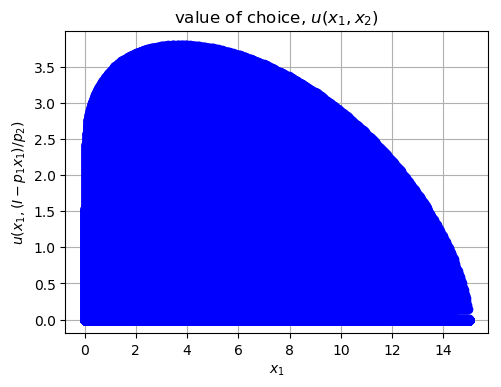

In [254]:
fig = plt.figure(figsize=(12,4),dpi=100) 
ax = fig.add_subplot(1,2,1)

ax.plot(x1_values,u_values, 'bo')

ax.set_title('value of choice, $u(x_1,x_2)$')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$u(x_1,(I-p_1 x_1)/p_2)$')
ax.grid(True)

# Extension of the model

Change in budget constraint.

Now we introduce a tax on good x2, which increases when consuming more of x2. The price is increased by 0.5 for each consumed x2.

\\[
\begin{eqnarray*}
V(p_{1},p_{2},I) & = & \max_{x_{1}\in X_1}(\alpha x_{1}^{-\rho}+(1-\alpha) x_{2}^{-\rho})^{-1/\rho}\\
 & \text{s.t.}\\
 p_{1}*x_{1}+(p_{2}+0.5*x_{2})*x_{2} & \leq & I,\,\,\,p_{1},p_{2},I>0\\
x_{1},x_{2} & \geq & 0
\end{eqnarray*}
\\]
 
    

In [255]:
alpha = 0.20 # preference parameter
rho = -0.20 # elasticity parameter
I = 30 # income
p1 = 2 # price 1
p2 = 4 # price 2

Again we use the SLSQP optimizer as it was the best one.

In [256]:
def value_of_choice(x,alpha,rho,I,p1,p2):
    x1 = x[0]
    x2 = x[1]
    return -u_func(x1,x2,alpha,rho)

# Constraint:
constraints = (
    {'type': 'ineq', 'fun': lambda x:  I-p1*x[0]-(p2+0.5*x[1])*x[1]}   
)
bounds = (
    (0,I/p1),
    (0,I/p2)
)

# Call the SLSQP optimizer:
initial_guess = [I/p1/2,I/p2/2]
sol_optimize = optimize.minimize(
    value_of_choice,initial_guess,args=(alpha,rho,I,p1,p2),
    method='SLSQP',bounds=bounds,constraints=constraints)

x1 = sol_optimize.x[0]
x2 = sol_optimize.x[1]
u = u_func(x1,x2,alpha,rho)
print_solution(x1,x2,u,I,p1,p2)

x1 = 3.71257356
x2 = 3.81982781
u  = 3.79818113
I-p1*x1-p2*x2 = 7.29554164


**Plot the solution**

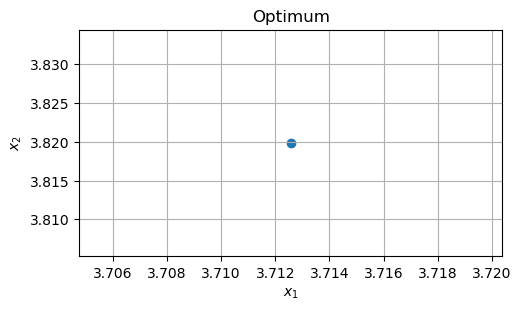

In [257]:
fig = plt.figure(figsize=(12,3),dpi=100) 
ax = fig.add_subplot(1,2,2)

ax.scatter(x1,x2)

ax.set_title('Optimum')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(True)

In [258]:
def _objective(x1,x2):
    return (0.2*x1**(2) + (1-0.2)*x2**(2))**(1/2)

def objective(x):
    return _objective(x[0],x[1])

def ineq_constraint(x):
    return I-p1*x[0]-(p2+0.5*x[1])*x[1]

def eq_constraint(x):
        income = 30 - p1*x[0]-(p2+0.5*x[1])*x[1]
        return income

**Solving by SLSQP optimizer and iterating gradient evaluations:**

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.813652031805698
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 5

x =  [3.15338676 3.96156096]


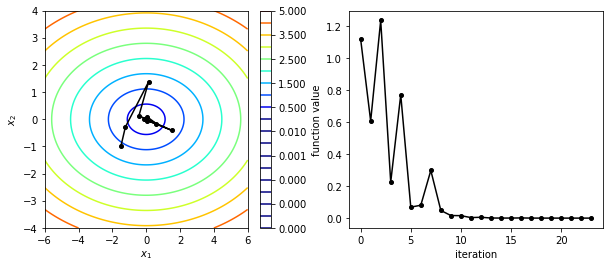

In [259]:
bound = (1.0,5.0)
bounds = (bound, bound)
ineq_con = {'type': 'ineq', 'fun': ineq_constraint} 
eq_con = {'type': 'eq', 'fun': eq_constraint}

x0=(1.0,1.0)
result = optimize.minimize(objective,x0,
                             method='SLSQP',
                             bounds=bounds,
                             constraints=[ineq_con,eq_con],
                             options={'disp':True})

print('\nx = ',result.x)
contour()

We now define the values for x1, x2 and u with the new budget constraint in order to plot the solution:

In [260]:
def values(alpha,rho,I,p1,p2,N1,N2,do_print=True):

    shape_tuple = (N1,N2)
    x1_values = np.empty(shape_tuple)
    x2_values = np.empty(shape_tuple)
    u_values = np.empty(shape_tuple)

    x1_best = 0
    x2_best = 0
    u_best = u_func(0,0,alpha=alpha,rho=rho)

    for i in range(N1):
        for j in range(N2):

            x1_values[i,j] = x1 = (i/(N1-1))*I/p1
            x2_values[i,j] = x2 = (j/(N2-1))*I/p2

            #Budget constraint:
            if p1*x1+(p2+0.5*x2)*x2 <= I:  
                u_values[i,j] = u_func(x1,x2,alpha=alpha,rho=rho)
            else: 
                u_values[i,j] = u_func(0,0,alpha=alpha,rho=rho)

            if u_values[i,j] > u_best:
                x1_best = x1_values[i,j]
                x2_best = x2_values[i,j] 
                u_best = u_values[i,j]

    if do_print:
        print_solution(x1_best,x2_best,u_best,I,p1,p2)

    return x1_best,x2_best,u_best,x1_values,x2_values,u_values

def print_solution(x1,x2,u,I,p1,p2):
    print(f'x1 = {x1:.8f}')
    print(f'x2 = {x2:.8f}')
    print(f'u  = {u:.8f}')
    print(f'I-p1*x1-(p2+0.5*x2)*x2 = {I-p1*x1-(p2+0.5*x2)*x2:.8f}') 

In [261]:
solution2 = values(alpha=0.20,rho=-0.2,I=30,p1=2,p2=4,N1=400,N2=600) 

x1 = 3.75939850
x2 = 3.80634391
u  = 3.79691751
I-p1*x1-(p2+0.5*x2)*x2 = 0.01170041


**Plot the solution**

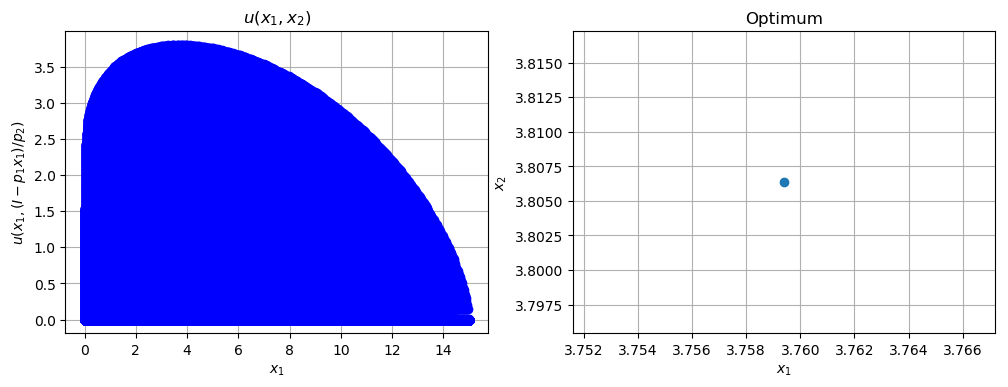

In [262]:
fig = plt.figure(figsize=(12,4),dpi=100) 

#Unpack solution:
x1_best,x2_best,u_best,x1_values,x2_values,u_values = solution2

# Left plot
ax_left = fig.add_subplot(1,2,1)
ax_left.plot(x1_values,u_values, 'ob')
ax_left.set_title('$u(x_1,x_2)$')
ax_left.set_xlabel('$x_1$')
ax_left.set_ylabel('$u(x_1,(I-p_1 x_1)/p_2)$')
ax_left.grid(True)

# Right plot
ax_right = fig.add_subplot(1,2,2)
ax_right.scatter(x1_best,x2_best)
ax_right.set_title('Optimum')
ax_right.set_xlabel('$x_1$')
ax_right.set_ylabel('$x_2$')
ax_right.grid(True)

From this we see that the plot has changed and the utillity is smaller than before introdusing the tax. The consumer now wish to consume almost as much of x1 as x2. The optimal amount of x1 is increased, but the utility curve is more flat than before. 